In [2]:
import warnings

import japanize_matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import HTML, display
from utils import get_finance_data

In [3]:
def DDTW(Q, C):
    """
    Args:
        Q (np.array or list): 一つ目の波形
        C (np.array or list): 二つ目の波形

    Returns:
        γ_mat (np.array): DDTWを計算するための行列
        arrows (np.array): 各時点で←・↙︎・↓のどのマスが最小だったかを示す記号を保存する行列
        ddtw (float): DDTW
    """
    Q, C = np.array(Q), np.array(C)
    assert Q.shape[0] > 3, "一つ目の波形のフォーマットがおかしいです。"
    assert C.shape[0] > 3, "二つ目の波形のフォーマットがおかしいです。"

    # 3.1 Algorithm details の式
    def _Dq(q):
        return ((q[1] - q[0]) + (q[2] - q[0]) / 2) / 2

    # 二つの時点間の距離
    def _γ(x, y):
        return abs(_Dq(x) - _Dq(y))

    # 各変数
    n, m = Q.shape[0] - 2, C.shape[0] - 2
    γ_mat = np.zeros((n, m))
    arrows = np.array(np.zeros((n, m)), dtype=str)  # 可視化用の行列でDDTWの値とは無関係

    # 一番左下のスタート地点
    γ_mat[0, 0] = _γ(Q[0:3], C[0:3])

    # 一列目を計算
    for i in range(1, n):
        γ_mat[i, 0] = γ_mat[i - 1, 0] + _γ(Q[i - 1 : i + 2], C[0:3])
        arrows[i, 0] = "↓"

    # 一行目を計算
    for j in range(1, m):
        γ_mat[0, j] = γ_mat[0, j - 1] + _γ(Q[0:3], C[j - 1 : j + 2])
        arrows[0, j] = "←"

    # 残りのマスを計算
    for i in range(1, n):
        for j in range(1, m):
            # DDTWを求めるためのマトリクスを埋める
            d_ij = _γ(Q[i - 1 : i + 2], C[j - 1 : j + 2])
            γ_mat[i, j] = d_ij + np.min(
                [γ_mat[i - 1, j - 1], γ_mat[i - 1, j], γ_mat[i, j - 1]]
            )

            # 矢印を書くための行列(DDTWの値とは関係無い処理)
            if (
                square_index := np.argmin(
                    [γ_mat[i - 1, j - 1], γ_mat[i - 1, j], γ_mat[i, j - 1]]
                )
            ) == 0:
                arrows[i, j] = "↙︎"
            elif square_index == 1:
                arrows[i, j] = "↓"
            elif square_index == 2:
                arrows[i, j] = "←"

    return γ_mat, arrows, γ_mat[n - 1, m - 1]

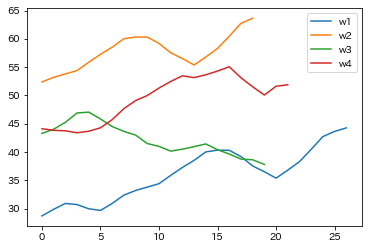

In [6]:
ticker_symbol = "ZIM"
start = "2021-01-01"
end = "2022-01-01"

# データを取得する
df1 = get_finance_data(ticker_symbol, start=start, end=end, savedir="data")

df1["Close"] = df1["Close"].rolling(window=3).mean().fillna(0)
w1, w2 = df1["Close"][53:80].values, df1["Close"][60:79].values + 20
w3, w4 = df1["Close"][100:120].values, df1["Close"][145:167].values - 5

plt.plot(w1, label="w1")
plt.plot(w2, label="w2")
plt.plot(w3, label="w3")
plt.plot(w4, label="w4")
plt.legend()

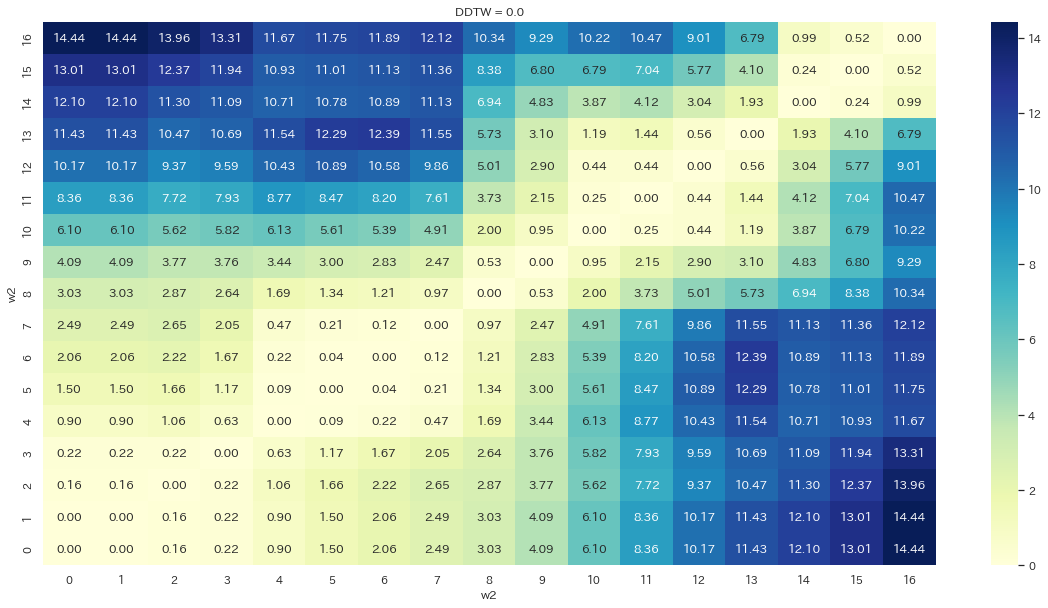

/Users/isshintoyonaga/.anyenv/envs/pyenv/versions/anaconda3-2022.05/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 65038 (\N{VARIATION SELECTOR-15}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


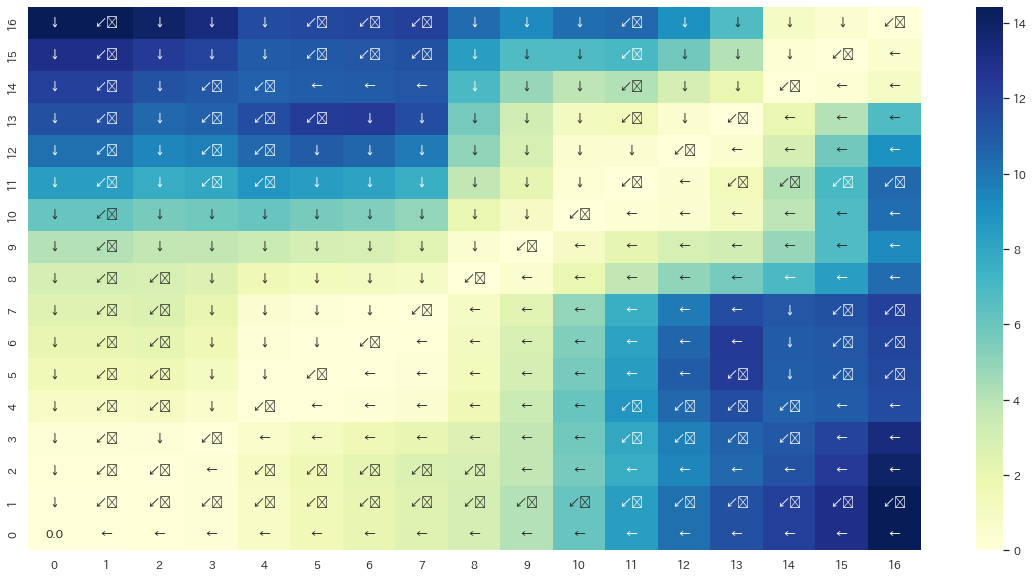

In [7]:
γ_mat, arrows, ddtw = DDTW(w2, w2)

sns.set(rc={"figure.figsize": (20, 10)})
sns.set(font="IPAexGothic")
ax = sns.heatmap(γ_mat, annot=True, fmt=".2f", cmap="YlGnBu")
ax.set_title(f"DDTW = {ddtw}")
ax.invert_yaxis()
ax.set_xlabel("w2")
ax.set_ylabel("w2")
plt.show()

ax = sns.heatmap(γ_mat, annot=arrows, fmt="", cmap="YlGnBu")
ax.invert_yaxis()
plt.show()

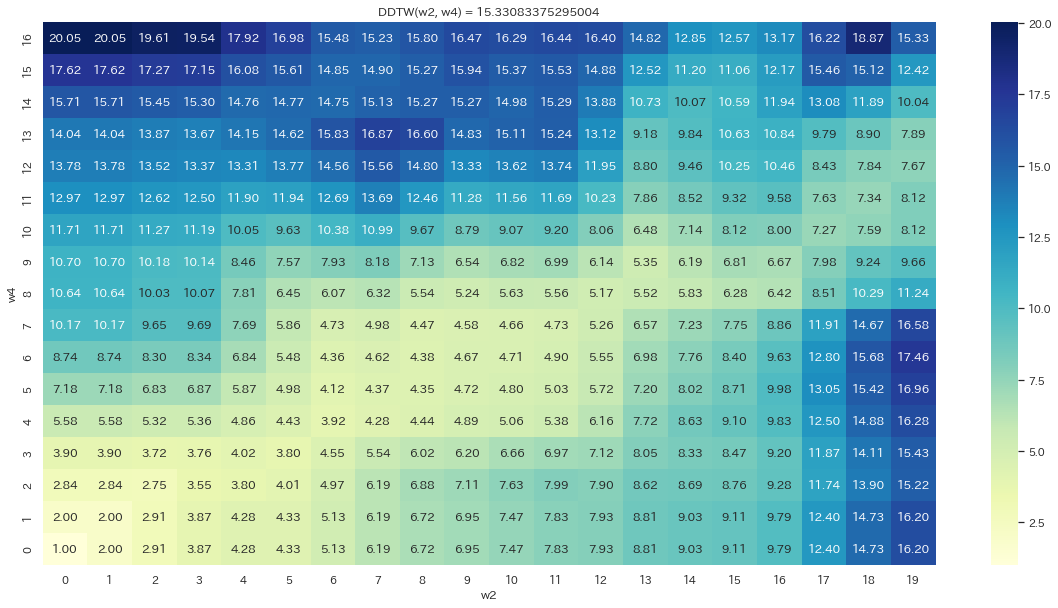

In [8]:
γ_mat, arrows, ddtw = DDTW(w2, w4)

sns.set(rc={"figure.figsize": (20, 10)})
sns.set(font="IPAexGothic")
ax = sns.heatmap(γ_mat, annot=True, fmt=".2f", cmap="YlGnBu")
ax.set_title(f"DDTW(w2, w4) = {ddtw}")
ax.invert_yaxis()
ax.set_xlabel("w2")
ax.set_ylabel("w4")
plt.show()